## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score, KFold, LeaveOneOut
from sklearn.linear_model import ElasticNet, Ridge, Lasso, Lars, LassoLars
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error


# another way of ignoring warnings
warnings.filterwarnings('ignore')

#### Loading dataset

In [2]:
Xtrain = pd.read_csv("Xytrain_regression.csv").iloc[:, 2:]
ytrain = pd.read_csv("Xytrain_regression.csv").iloc[:, 1]

Xtest = pd.read_csv("Xytest_regression.csv").iloc[:, 2:]
ytest = pd.read_csv("Xytest_regression.csv").iloc[:, 1]

### Ridge Regression

/Users/onasaulianskaite/micromamba/envs/swallow/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/onasaulianskaite/micromamba/envs/swallow/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/onasaulianskaite/micromamba/envs/swallow/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/onasaulianskaite/micromamba/envs/swallow/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/onasaulianskaite/micromamba/envs/swallow/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:254: User

Best parameters for Ridge:  {'alpha': 6.127659574468085}
Best cross-validation score: 0.7360
R² Score on the test dataset: 0.7769
MSE on the test dataset: 1148.4996
RMSE on the test dataset: 33.8895


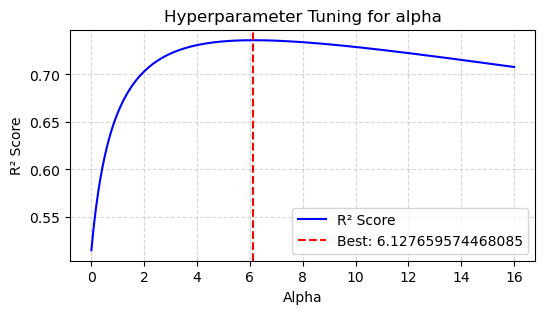

Best estimator: Ridge(alpha=6.127659574468085)


In [3]:
# Initialize Ridge regression model
ridge = Ridge()

# Define the hyperparameter grid for alpha
param_grid_ridge = {
    'alpha' : np.linspace(0, 16, 800)
}

# Define KFold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#cv = LeaveOneOut()

# Use GridSearchCV with the KFold object
Ridge_ = GridSearchCV(ridge, param_grid_ridge, cv=cv, n_jobs=-1, return_train_score=True, scoring='r2')

# Fit the GridSearchCV
Ridge_.fit(Xtrain, ytrain)

# Print best parameters and best cross-validation score
print("Best parameters for Ridge: ", Ridge_.best_params_)
print("Best cross-validation score: {:.4f}".format(Ridge_.best_score_))

# Evaluate the best model on the test data
best_model_ridge = Ridge_.best_estimator_
y_pred_ridge = best_model_ridge.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_ridge)
test_MSE = mean_squared_error(ytest, y_pred_ridge)
test_RMSE = root_mean_squared_error(ytest, y_pred_ridge)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

# Get the mean test scores from the cross-validation results
alphas = np.linspace(0, 16, 800)
mean_test_scores = Ridge_.cv_results_['mean_test_score']

# Plot the results of hyperparameter tuning
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='R² Score')
plt.axvline(Ridge_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {Ridge_.best_params_['alpha']}")
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Hyperparameter Tuning for alpha')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {Ridge_.best_estimator_}')

In [4]:
# Get the mean test R² scores and standard deviations
meanError = list(Ridge_.cv_results_['mean_test_score'])
stdError = Ridge_.cv_results_['std_test_score']

# Find the index of the model with the highest mean R² score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

# Select the model with the highest alpha (if there are multiple models that satisfy the condition)
if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {Ridge_.cv_results_["param_alpha"][j]}')
print(f'One standard error rule gives the best model with mean_test_score (R²): {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 16.0
One standard error rule gives the best model with mean_test_score (R²): 0.7077696564478526 and std_test_score: 0.10923708913402061


In [5]:
alpha = Ridge_.cv_results_["param_alpha"][j]

# Ridge Model (alpha=10)
ridge = Ridge(alpha=alpha)
ridge.fit(Xtrain, ytrain)
y_pred_ridge = ridge.predict(Xtest)

df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_ridge,
    'Squared Error (SE)': (ytest - y_pred_ridge) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_ridge)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

r2_ridge = r2_score(ytest, y_pred_ridge)
print(f'R² score for Ridge: {r2_ridge:.4f}')

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

R² score for Ridge: 0.7576
Mean Squared Error (MSE): 1247.71
Root Mean Squared Error (RMSE): 35.32
Standard Deviation of Actual Values: 73.61


### Lasso Regression

Best parameters for Lasso found:  {'alpha': 1.7672090112640801}
Best cross-validation score for Lasso: 0.8352
R² Score on the test dataset: 0.8369
MSE on the test dataset: 839.4323
RMSE on the test dataset: 28.9730


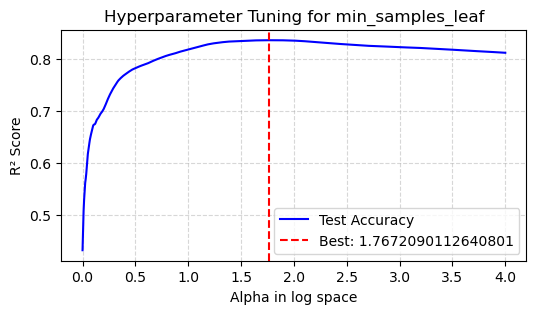

Best estimator: Lasso(alpha=1.7672090112640801)


In [6]:
# Initialize the Lasso model
lasso = Lasso()

# Define the hyperparameter grid for Lasso
param_grid_lasso = {
    'alpha': np.linspace(0, 4, 800)  # Fixed logspace range
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Set up the grid search with 5-fold cross-validation
Lasso_ = GridSearchCV(lasso, param_grid_lasso, cv=cv, scoring='r2')

# Fit the grid search to your training data
Lasso_.fit(Xtrain, ytrain)

# Print the best parameters and score
print("Best parameters for Lasso found: ", Lasso_.best_params_)
print("Best cross-validation score for Lasso: {:.4f}".format(Lasso_.best_score_))

# Access the best model
best_model_lasso = Lasso_.best_estimator_

# Make predictions on the test set
y_pred_lasso = best_model_lasso.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_lasso)
test_MSE = mean_squared_error(ytest, y_pred_lasso)
test_RMSE = root_mean_squared_error(ytest, y_pred_lasso)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

alphas = np.linspace(0, 4, 800) 
mean_test_scores = Lasso_.cv_results_['mean_test_score']

# Plot results
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='Test Accuracy')
plt.axvline(Lasso_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {Lasso_.best_params_['alpha']}")
plt.xlabel('Alpha in log space')
plt.ylabel('R² Score')
plt.title('Hyperparameter Tuning for min_samples_leaf')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {Lasso_.best_estimator_}')

In [7]:
meanError = list(Lasso_.cv_results_['mean_test_score'])
stdError = Lasso_.cv_results_['std_test_score']

# Find the index of the model with the highest mean test score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
# We flip the sign of the std_error and compare
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {Lasso_.cv_results_["param_alpha"][j]}')
print(f'One standard error rule gives the best model with mean_test_score: {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 4.0
One standard error rule gives the best model with mean_test_score: 0.8111314103928379 and std_test_score: 0.08944267858113543


In [8]:
alpha = Lasso_.cv_results_["param_alpha"][j]

# Ridge Model (alpha=10)
lasso = Lasso(alpha=alpha)
lasso.fit(Xtrain, ytrain)
y_pred_lasso = lasso.predict(Xtest)
r2_lasso = r2_score(ytest, y_pred_lasso)
print(f'R² score for Lasso: {r2_lasso:.4f}')

df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_lasso,
    'Squared Error (SE)': (ytest - y_pred_lasso) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_lasso)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

R² score for Lasso: 0.7947
Mean Squared Error (MSE): 1056.98
Root Mean Squared Error (RMSE): 32.51
Standard Deviation of Actual Values: 73.61


### ElasticNEt REgression

In [9]:
# Initialize the ElasticNet model
elasticNet = ElasticNet()

# Define the hyperparameter grid for ElasticNet
param_grid_en = {
    'alpha': np.linspace(0, 2, 200) ,  # Alpha on a log scale from 0.001 to 1
    'l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Set up the grid search with 10-fold cross-validation
EN_ = GridSearchCV(elasticNet, param_grid_en, cv=cv, scoring='r2')

# Fit the grid search to your training data
EN_.fit(Xtrain, ytrain)

# Print the best parameters and score
print("Best parameters for ElasticNet found: ", EN_.best_params_)
print("Best cross-validation score for ElasticNet: {:.4f}".format(EN_.best_score_))

# Access the best model
best_model_en = EN_.best_estimator_

# Make predictions on the test set
y_pred_en = best_model_en.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_en)
test_MSE = mean_squared_error(ytest, y_pred_en)
test_RMSE = root_mean_squared_error(ytest, y_pred_en)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

# Extract the mean_test_score and reshape it to fit the grid of alphas and l1_ratios
mean_test_scores = EN_.cv_results_['mean_test_score'].reshape(len(param_grid_en['l1_ratio']), len(param_grid_en['alpha']))

Best parameters for ElasticNet found:  {'alpha': 1.7688442211055277, 'l1_ratio': 1}
Best cross-validation score for ElasticNet: 0.8352
R² Score on the test dataset: 0.8369
MSE on the test dataset: 839.4871
RMSE on the test dataset: 28.9739


In [10]:
# Retrieve the cross-validation results for ElasticNet
meanError = list(EN_.cv_results_['mean_test_score'])
stdError = EN_.cv_results_['std_test_score']

# Find the index of the model with the highest mean test score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
# We check if any models' mean test score is within one standard error of the best model's score
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler model with a higher alpha)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
selected_alpha = EN_.cv_results_['param_alpha'][j]
selected_l1_ratio = EN_.cv_results_['param_l1_ratio'][j]

print(f'One standard error rule selects model with alpha: {selected_alpha} and l1_ratio: {selected_l1_ratio}')
print(f'One standard error rule gives the best model with mean_test_score: {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 2.0 and l1_ratio: 1.0
One standard error rule gives the best model with mean_test_score: 0.8343988970447255 and std_test_score: 0.0777079935175266


In [11]:
alpha = EN_.cv_results_["param_alpha"][j]

# Ridge Model (alpha=10)
en = ElasticNet(alpha=selected_alpha, l1_ratio=selected_l1_ratio)
en.fit(Xtrain, ytrain)
y_pred_en = en.predict(Xtest)
r2_en = r2_score(ytest, y_pred_en)
print(f'R² score for ElasticNet: {r2_en:.4f}')

df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_en,
    'Squared Error (SE)': (ytest - y_pred_en) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_en)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

R² score for ElasticNet: 0.8343
Mean Squared Error (MSE): 852.85
Root Mean Squared Error (RMSE): 29.20
Standard Deviation of Actual Values: 73.61


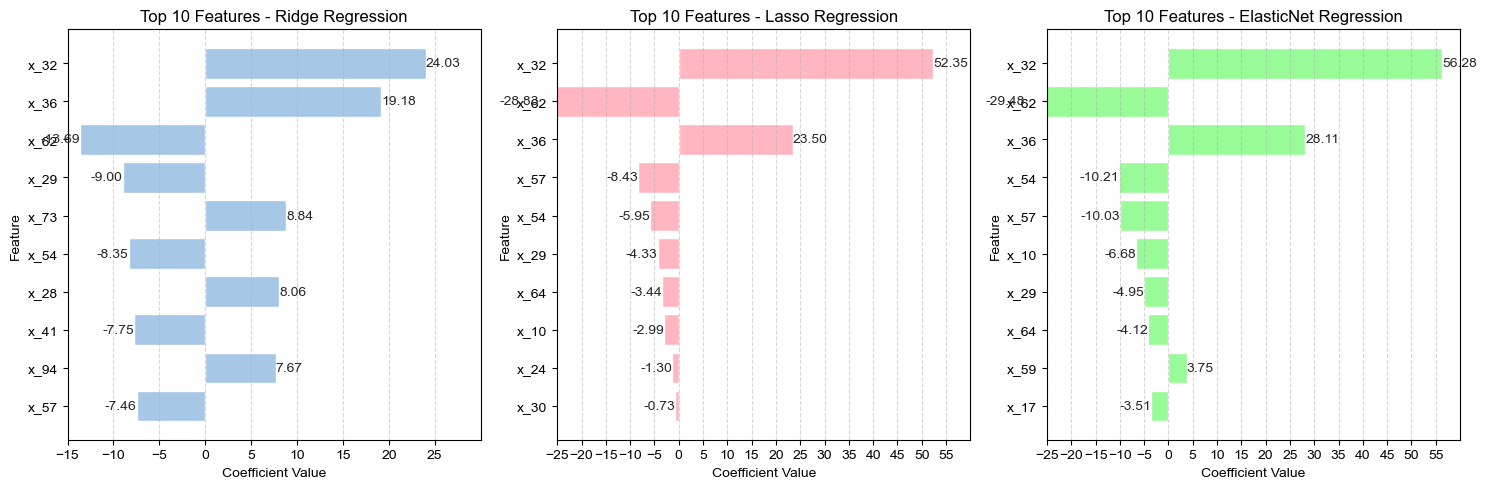

In [12]:
# Feature names (assuming Xtrain is a DataFrame, otherwise use indices)
feature_names = Xtrain.columns

def get_top_features(model):
    """Extract top 10 features based on absolute weight values."""
    coef = model.coef_
    abs_coef = np.abs(coef)
    
    # Get indices of top 10 features
    top_indices = np.argsort(abs_coef)[-10:]  # Top 10 by absolute magnitude
    
    # Get feature names and corresponding values
    top_features = [feature_names[i] for i in top_indices]
    top_values = coef[top_indices]
    
    return top_features, top_values

# Get top features for each model
ridge_features, ridge_values = get_top_features(ridge)
lasso_features, lasso_values = get_top_features(lasso)
en_features, en_values = get_top_features(en)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Use Seaborn style for pastel aesthetics
sns.set_style("whitegrid")

# Define pastel colors
colors = ["#A7C7E7", "#FFB6C1", "#98FB98"]  # Pastel Blue, Pastel Pink, Pastel Green

# Function to plot bars with values on top
def plot_feature_importance(ax, features, values, title, color, xlim_range):
    ax.barh(features, values, color=color)
    ax.set_title(title)
    ax.set_xlabel("Coefficient Value")
    ax.set_ylabel("Feature")
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_xlim(xlim_range[0], xlim_range[1])
    ax.set_xticks(np.arange(xlim_range[0], xlim_range[1], 5))

    # Add value labels
    for i, v in enumerate(values):
        ax.text(v, i, f"{v:.2f}", va='center', ha="left" if v > 0 else "right", fontsize=10)

# Plot Ridge
plot_feature_importance(axes[0], ridge_features, ridge_values, "Top 10 Features - Ridge Regression", colors[0], (-15, 30))

# Plot Lasso
plot_feature_importance(axes[1], lasso_features, lasso_values, "Top 10 Features - Lasso Regression", colors[1], (-25, 60))

# Plot ElasticNet
plot_feature_importance(axes[2], en_features, en_values, "Top 10 Features - ElasticNet Regression", colors[2], (-25, 60))

# Adjust layout
plt.tight_layout()
plt.show()

#### Least angle regression and selection (LARS)

The Least Angle Regression (LARS) method The Lasso strategy in linear regression combines the regularization capabilities of L1 regularization (also called Lasso) with the efficiency of forward selection. Loss of arousal As it moves in the direction of the target variable's greatest correlation, Lasso gradually adds features to the model. This process is continued until a point is reached at which the correlation between the additional variable and the original one would be equal. Due to its tendency to choose a sparse subset of characteristics, this approach works especially well with high-dimensional data. Models with fewer non-zero coefficients are encouraged to be sparse by the regularization term (L1 penalty).

Positive LAsso: Better Stability: Helps avoid issues when highly correlated features lead to coefficients flipping signs.

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Best n_nonzero_coefs: 1.49
Best Cross-Validation R² score: 0.8336
R² Score on the test dataset: 0.8378
MSE on the test dataset: 834.7278
RMSE on the test dataset: 28.8917


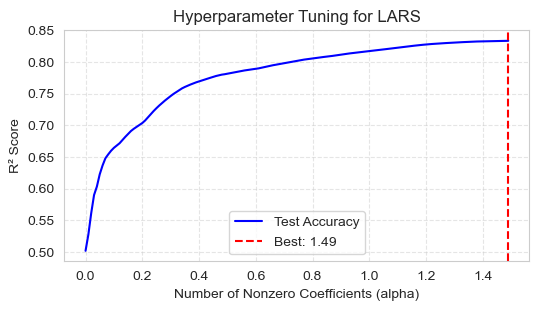

Best estimator: LassoLars(alpha=1.49)


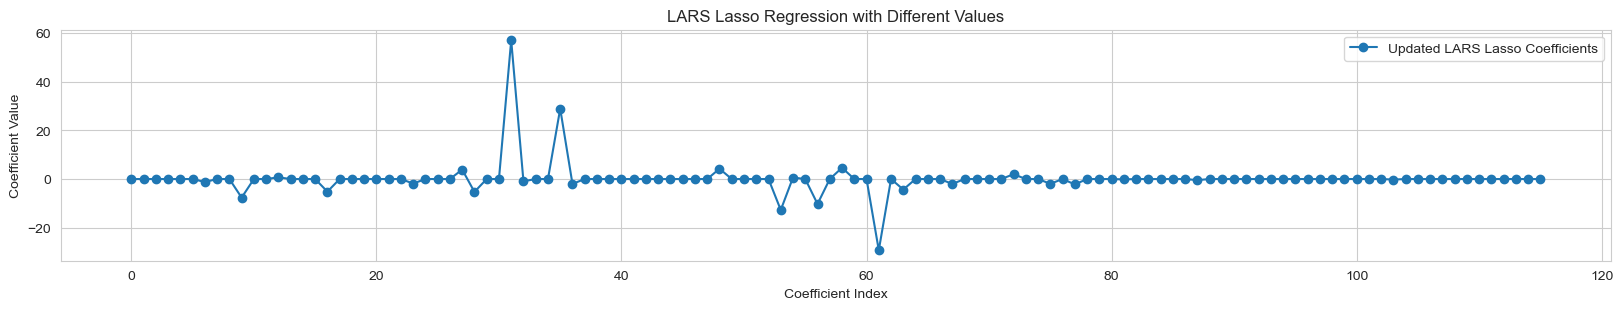

In [13]:
# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define hyperparameter grid
param_grid = {
    "alpha": np.arange(0, 1.5, 0.01)
} 

# Define Lars model
lassolars = LassoLars()

# Use GridSearchCV
LAssoLars_ = GridSearchCV(lassolars, param_grid, scoring="r2", cv=kf, n_jobs=-1, verbose=1)
LAssoLars_.fit(Xtrain, ytrain)

# Get best parameters & results
best_n = LAssoLars_.best_params_["alpha"]
best_mse = LAssoLars_.best_score_

print(f"Best n_nonzero_coefs: {best_n}")
print(f"Best Cross-Validation R² score: {best_mse:.4f}")

# Access the best model
best_model_lars = LAssoLars_.best_estimator_

# Make predictions on the test set
y_pred_lars = best_model_lars.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_lars)
test_MSE = mean_squared_error(ytest, y_pred_lars)
test_RMSE = root_mean_squared_error(ytest, y_pred_lars)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

alphas = np.arange(0, 1.5, 0.01)
mean_test_scores = LAssoLars_.cv_results_['mean_test_score']

# Plot results
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='Test Accuracy')
plt.axvline(LAssoLars_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {LAssoLars_.best_params_['alpha']}")
plt.xlabel('Number of Nonzero Coefficients (alpha)')
plt.ylabel('R² Score')
plt.title('Hyperparameter Tuning for LARS')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {LAssoLars_.best_estimator_}')

plt.figure(figsize=(20, 3))
plt.plot(best_model_lars.coef_, marker='o', label='Updated LARS Lasso Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.title('LARS Lasso Regression with Different Values')
plt.show()

In [14]:
# Retrieve cross-validation results for LARS
meanError = list(LAssoLars_.cv_results_['mean_test_score'])  # Mean R² scores
stdError = LAssoLars_.cv_results_['std_test_score']  # Standard deviation of R² scores

# Find the index of the best-performing model (highest mean test score)
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

# Select the most regularized model within the one standard error range
if len(J) > 0:
    j = int(J[-1])  # Choose the most regularized model (simpler with fewer nonzero coefficients)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one
    
# Print results
print(f'One Standard Error Rule selects model with alpha: {LAssoLars_.cv_results_["param_alpha"][j]}')
print(f'Mean R² Score: {meanError[j]:.4f}, Std Error: {stdError[j]:.4f}')

One Standard Error Rule selects model with alpha: 1.49
Mean R² Score: 0.8336, Std Error: 0.0732


In [15]:
param_alpha = LAssoLars_.cv_results_["param_alpha"][j]

# Ridge Model (alpha=10)
lassolars = LassoLars(alpha = param_alpha)
lassolars.fit(Xtrain, ytrain)
y_pred_lassolars = lassolars.predict(Xtest)
r2_lassolars = r2_score(ytest, y_pred_lassolars)
print(f'R² score for LAssoLars: {r2_lassolars:.4f}')

R² score for LAssoLars: 0.8378


In [16]:
# Get non-zero coefficients and corresponding feature indices
non_zero_indices = lassolars.coef_ != 0
non_zero_features = Xtrain.columns[non_zero_indices]  # Feature names (if using Pandas)
non_zero_coefs = lassolars.coef_[non_zero_indices]  # Corresponding coefficients

# Print results
print("Selected Features and Coefficients:")
for feature, coef in zip(non_zero_features, non_zero_coefs):
    print(f"{feature}: {coef:.4f}")

Selected Features and Coefficients:
x_07: -1.2235
x_10: -7.6394
x_13: 0.7020
x_17: -5.1813
x_24: -1.8655
x_28: 3.8847
x_29: -5.2832
x_32: 57.0611
x_33: -0.9338
x_36: 28.9130
x_37: -2.0013
x_49: 4.2282
x_54: -12.7221
x_55: 0.6115
x_57: -10.2459
x_59: 4.6429
x_62: -29.2652
x_64: -4.3272
x_68: -2.0222
x_73: 1.9882
x_76: -1.9558
x_78: -2.2115
x_82: -0.1567
x_88: -0.4492
C_03_73.0: -0.2161


In [17]:
df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_lassolars,
    'Squared Error (SE)': (ytest - y_pred_lassolars) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_lassolars)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}\n")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

print(df_compare)

Mean Squared Error (MSE): 834.73
Root Mean Squared Error (RMSE): 28.89
Standard Deviation of Actual Values: 73.61

        Actual   Predicted  Squared Error (SE)  Absolute Error (AE)
0   284.455979  275.862743           73.843694             8.593235
1   320.416003  283.865643         1335.928845            36.550360
2   263.829292  285.772616          481.509494            21.943325
3   203.955710  236.471651         1057.286415            32.515941
4    81.930571  115.292913         1113.045920            33.362343
5   174.769693  160.192626          212.490906            14.577068
6   215.202877  197.581721          310.505140            17.621156
7   129.685034  137.951562           68.335496             8.266529
8   197.422104  180.680436          280.283465            16.741669
9   272.981527  262.837386          102.903583            10.144140
10  154.344205  213.375302         3484.670461            59.031097
11  155.322279  163.346362           64.385898             8.024082
1

Lasso and Elastic Net use a coordinate descent method to compute the paths, while Lasso-LARS uses the LARS algorithm to compute the paths.

#### Compare Lasso and Lasso-LARS paths

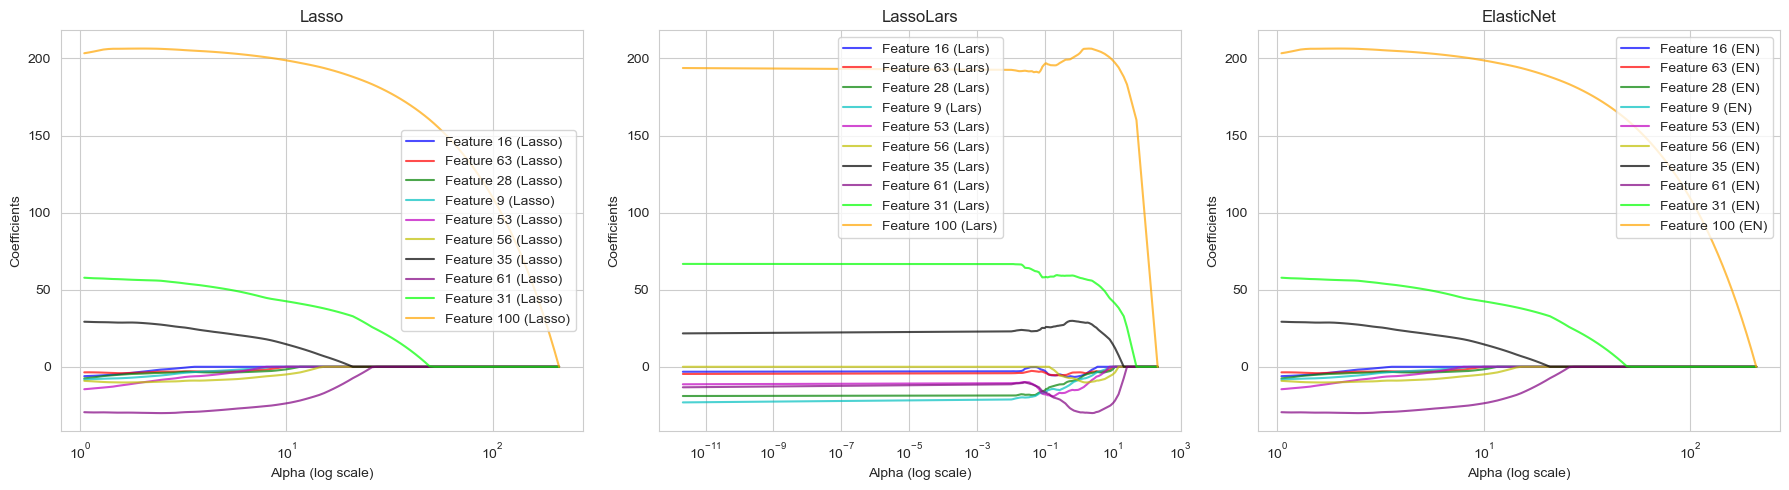

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.linear_model import enet_path, lasso_path, lars_path

# Convert Xtrain and ytrain to NumPy arrays
Xtrain_np = np.ascontiguousarray(Xtrain.to_numpy())  
ytrain_np = np.ascontiguousarray(ytrain.to_numpy())

# Extract best hyperparameters from GridSearchCV
best_alpha_lassolars = LAssoLars_.best_params_['alpha']
best_alpha_lasso = Lasso_.best_params_['alpha']
best_alpha_en = EN_.best_params_['alpha']
best_l1_ratio_en = EN_.best_params_['l1_ratio']

eps = 5e-3  # Controls regularization path resolution

# Compute paths
alphas_lasso, coefs_lasso, _ = lasso_path(Xtrain_np, ytrain_np, eps=eps)
alphas_lars, active, coefs_lars = lars_path(Xtrain_np, ytrain_np, method="lasso")
alphas_enet, coefs_enet, _ = enet_path(Xtrain_np, ytrain_np, eps=eps, l1_ratio=best_l1_ratio_en)

# Identify top 10 most important features based on coefficient magnitudes
importance = np.abs(coefs_lasso).sum(axis=1)  # Sum of absolute values across paths
top_10_idx = np.argsort(importance)[-10:]  # Get indices of top 10 most important features

# Set up plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  
colors = cycle(["b", "r", "g", "c", "m", "y", "k", "purple", "lime", "orange"])  # 10 colors

# --- PLOT 1: Lasso vs ElasticNet ---
ax = axes[0]
for idx, c in zip(top_10_idx, colors):
    ax.semilogx(alphas_lasso, coefs_lasso[idx, :], linestyle='-', c=c, alpha=0.7, label=f"Feature {idx} (Lasso)")
ax.set_title("Lasso")
ax.set_xlabel("Alpha (log scale)")
ax.set_ylabel("Coefficients")
ax.legend(loc="best")

# --- PLOT 2: Lasso vs LassoLars ---
ax = axes[1]
for idx, c in zip(top_10_idx, colors):
    ax.semilogx(alphas_lars, coefs_lars[idx, :], linestyle='-', c=c, alpha=0.7, label=f"Feature {idx} (Lars)")
ax.set_title("LassoLars")
ax.set_xlabel("Alpha (log scale)")
ax.set_ylabel("Coefficients")
ax.legend(loc="best")

# --- PLOT 3: LassoLars vs ElasticNet ---
ax = axes[2]
for idx, c in zip(top_10_idx, colors):
    ax.semilogx(alphas_enet, coefs_enet[idx, :], linestyle='-', c=c, alpha=0.7, label=f"Feature {idx} (EN)")
ax.set_title("ElasticNet")
ax.set_xlabel("Alpha (log scale)")
ax.set_ylabel("Coefficients")
ax.legend(loc="best")

# Adjust layout and show plots
plt.tight_layout()
plt.show()